In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation, performance_metrics
from datetime import datetime
import geopandas as gpd
import sys
sys.path.append('energy/')
import utils
%matplotlib inline

In [31]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

In [32]:
pd.options.mode.chained_assignment = None  # default='warn'

In [33]:
#viz setup
# sns.set(style='whitegrid',font_scale=1.75,rc={"axes.spines.top":False,"axes.spines.right":False, "lines.linewidth": 2.5,'lines.markersize': 10},color_codes=False,palette=sns.color_palette(['#27a3aa','#f76d23','#70d6e3','#ffbb31','#b1c96d','#cce18a','#1c4c5d','#787642']))
sns.set(style='whitegrid',font_scale=1.25,rc={"axes.spines.top":False,"axes.spines.right":False, "lines.linewidth": 2.5,'lines.markersize': 10},color_codes=False,palette=sns.color_palette(['#27a3aa','#f76d23','#70d6e3','#ffbb31','#b1c96d','#cce18a','#1c4c5d','#787642']))

In [86]:
energy_data = pd.read_csv('../data/energy_data.csv')

In [87]:
energy_data.date = pd.to_datetime(energy_data.date)

In [88]:
energy_data = energy_data.dropna()
energy_data = energy_data[energy_data.consumers > 0]

In [89]:
energy_data.tail()

,month,sales_mkwh,state,sector,consumers,price,revenue,use_per_capita,region,cooling_days,...,mon,season,date,num_days,num_hols,pct_weekdays,y,hot,cold,wind
16263,202103,114177.60253,USA,RES,137727290.0,13.239410,1.511644e+06,829.012192,PUS,28.144002,...,3,spring,2021-03-01,31,8,0.741935,26.742329,0.0,0.0,0.0
16264,202104,97874.63383,USA,COM,18871777.0,10.937048,1.070460e+06,5186.296650,PUS,36.803609,...,4,spring,2021-04-01,30,8,0.733333,172.876555,0.0,0.0,0.0
16265,202104,93833.56430,USA,RES,136903106.0,13.705571,1.286043e+06,685.401282,PUS,36.803609,...,4,spring,2021-04-01,30,8,0.733333,22.846709,0.0,0.0,0.0
16266,202105,103992.29422,USA,COM,18861146.0,10.774514,1.120466e+06,5513.572411,PUS,102.374190,...,5,spring,2021-05-01,31,11,0.645161,177.857175,0.0,0.0,0.0
16267,202105,101114.95221,USA,RES,136717815.0,13.652533,1.380475e+06,739.588708,PUS,102.374190,...,5,spring,2021-05-01,31,11,0.645161,23.857700,0.0,0.0,0.0


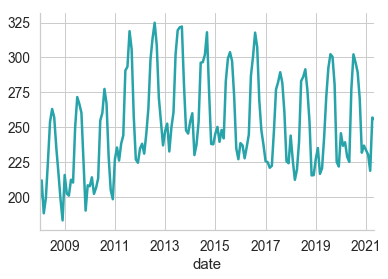

In [90]:
energy_data[(energy_data.state == 'TX')&(energy_data.sector=='COM')].set_index('date').sort_index().y.plot()

#### Removing outliers

In [91]:
energy_data = energy_data.set_index('date')

In [92]:
energy_data

,month,sales_mkwh,state,sector,consumers,price,revenue,use_per_capita,region,cooling_days,...,year,mon,season,num_days,num_hols,pct_weekdays,y,hot,cold,wind
date,,,,,,,,,,,,,,,,,,,,,
2021-05-01,202105,2191.98207,AL,RES,2299125.0,13.540000,2.967944e+04,953.398389,ESC,109.419607,...,2021,5,spring,31,11,0.645161,30.754787,0.153846,0.0,6.307692
2021-04-01,202104,1978.04896,AL,RES,2294478.0,13.730000,2.715861e+04,862.091055,ESC,17.744106,...,2021,4,spring,30,8,0.733333,28.736369,0.000000,3.0,5.000000
2021-03-01,202103,2321.97408,AL,RES,2295326.0,13.350000,3.099835e+04,1011.609715,ESC,33.840873,...,2021,3,spring,31,8,0.741935,32.632571,0.000000,0.0,10.000000
2021-02-01,202102,2906.25268,AL,RES,2247306.0,12.990000,3.775222e+04,1293.216269,ESC,0.817566,...,2021,2,winter,28,9,0.678571,46.186295,0.000000,12.0,1.000000
2021-01-01,202101,3164.80449,AL,RES,2284207.0,12.380000,3.918028e+04,1385.515625,ESC,5.622370,...,2021,1,winter,31,12,0.612903,44.694052,0.000000,2.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-01,202103,114177.60253,USA,RES,137727290.0,13.239410,1.511644e+06,829.012192,PUS,28.144002,...,2021,3,spring,31,8,0.741935,26.742329,0.000000,0.0,0.000000
2021-04-01,202104,97874.63383,USA,COM,18871777.0,10.937048,1.070460e+06,5186.296650,PUS,36.803609,...,2021,4,spring,30,8,0.733333,172.876555,0.000000,0.0,0.000000
2021-04-01,202104,93833.56430,USA,RES,136903106.0,13.705571,1.286043e+06,685.401282,PUS,36.803609,...,2021,4,spring,30,8,0.733333,22.846709,0.000000,0.0,0.000000


In [93]:
filtered_data = energy_data.groupby(['state','sector']).apply(utils.median_filter).reset_index()

In [94]:
filtered_data

,state,sector,date,y
0,AL,COM,2021-05-01,152.056253
1,AL,COM,2021-04-01,145.325290
2,AL,COM,2021-03-01,142.327315
3,AL,COM,2021-02-01,158.914160
4,AL,COM,2021-01-01,152.292452
...,...,...,...,...
16095,WY,RES,2008-05-01,24.208846
16096,WY,RES,2008-04-01,30.518669
16097,WY,RES,2008-03-01,33.312168
16098,WY,RES,2008-02-01,39.962770


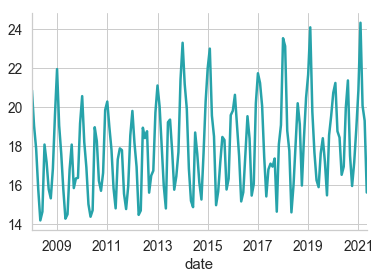

In [95]:
filtered_data[(filtered_data.state=='ME')&(filtered_data.sector=='RES')].set_index('date').y.plot()

In [96]:
energy_data = energy_data.reset_index().drop(columns='y').merge(filtered_data,how='left',on=['date','state','sector'])

In [97]:
energy_data[(energy_data.state=='NY')&(energy_data.sector=='RES')].columns

Index(['date', 'month', 'sales_mkwh', 'state', 'sector', 'consumers', 'price',
       'revenue', 'use_per_capita', 'region', 'cooling_days', 'heating_days',
       'COM', 'RES', 'time', 'year', 'mon', 'season', 'num_days', 'num_hols',
       'pct_weekdays', 'hot', 'cold', 'wind', 'y'],
      dtype='object')

Text(0, 0.5, 'Daily energy user per capita (kWh)')

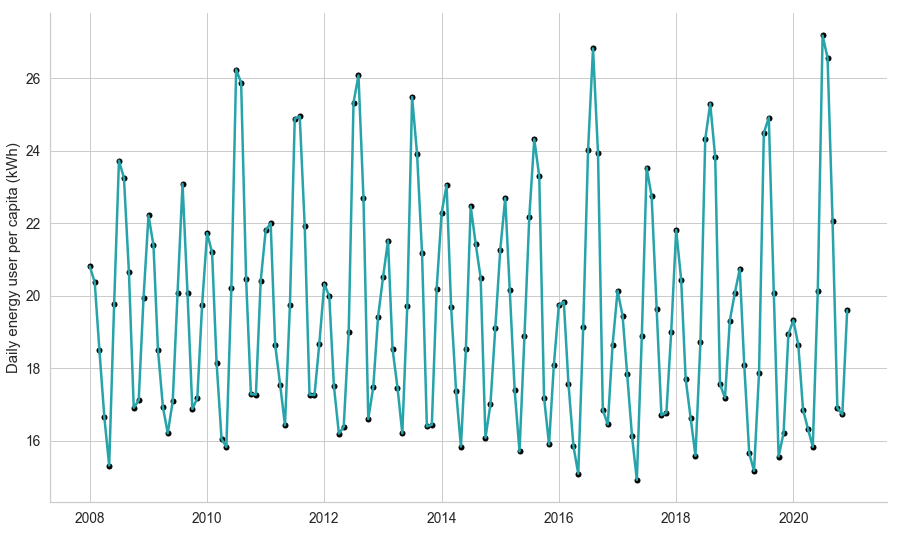

In [98]:
fig,ax = plt.subplots(figsize=(15,9))
plt.scatter(x='date',y='y',data=energy_data[(energy_data.state=='NY')&(energy_data.sector=='RES')&(energy_data.year<2021)],color='k',s=25,label='')
sns.lineplot(x='date',y='y',data=energy_data[(energy_data.state=='NY')&(energy_data.sector=='RES')&(energy_data.year<2021)],ax=ax)
plt.xlabel('')
plt.ylabel('Daily energy user per capita (kWh)')

In [ ]:
utils.get_model_for_state_sector(energy_data,'TN','COM',plot_forecast=True, changepoint_prior_scale=0.25,split_year=2020,samples=300)

In [ ]:
energy_data.date.value_counts()

## FB Prophet analysis

In [ ]:
utils.get_model_for_state_sector(energy_data,'TN','RES',changepoint_prior_scale=0.25)

In [ ]:
utils.get_model_for_state_sector(energy_data,'NJ','RES',changepoint_prior_scale=0.1)

In [ ]:
utils.get_model_for_state_sector(energy_data,'PA','RES',changepoint_prior_scale=0.1)

In [ ]:
energy_data = energy_data[~energy_data.state.isin(['USA','DC'])]

### Running for each State and Sector

In [ ]:
# %%timeit
states = list(energy_data.state.unique())
# states = ['NY']
sectors = list(energy_data.sector.unique())
# sectors = ['RES','COM']
idx = 0
for state in states:
    for sector in sectors:
        
        state_sector = "{}-{}".format(state, sector)
        print(state_sector)
        ## Defining Training Data 
        df_model = energy_data[(energy_data.state == state)&(energy_data.sector == sector)].copy().set_index('date').sort_index()
        df_train, df_test = utils.prepare_data(df_model[['y','heating_days','cooling_days','pct_weekdays','hot','cold','wind']], 2020)
        regressors_df = df_model[['heating_days','cooling_days','pct_weekdays','hot','cold','wind']].copy()
        
        ## Fitting model
        m = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=5,daily_seasonality=False,weekly_seasonality=False,mcmc_samples=300,
                changepoint_prior_scale=0.25, changepoint_range=0.95)
        m.add_regressor('heating_days', mode='additive')
        m.add_regressor('cooling_days', mode='additive')
        m.add_regressor('pct_weekdays', mode='additive')
        m.add_regressor('hot', mode='additive')
        m.add_regressor('cold', mode='additive')
        m.add_regressor('wind', mode='additive')
        m_fit = m.fit(df_train,control={'max_treedepth': 15})
        
        ## Getting forecasts
        future = m_fit.make_future_dataframe(periods = 17, freq = 'MS')
        future = utils.add_regressor_to_future(future, regressors_df)
        forecast = m_fit.predict(future)
        # fig = m_fit.plot(forecast)
        forecast['state'] = state
        forecast['sector'] = sector
               
        if idx == 0:
            predictions = forecast[['ds','yhat','state','sector','yhat_upper','yhat_lower']].copy()    
        else:
            predictions = predictions.append(forecast[['ds','yhat','state','sector','yhat_upper','yhat_lower']])
            
        idx = idx +1


In [ ]:
future

In [ ]:
m_fit.predict(future)

In [ ]:
sns.palplot(sns.color_palette(['#27a3aa','#f76d23','#70d6e3','#ffbb31','#b1c96d','#cce18a','#1c4c5d','#787642']))

In [ ]:
forecast = m_fit.predict(df_train)
p = utils.prophet_plot(m_fit,forecast,uncertainty=True,col='#27a3aa',include_legend=True,ylabel='Daily energy user per capita (kWh)',xlabel='',figsize=(15,9))

In [ ]:
predictions = predictions.rename(columns={'ds':'date'})

In [ ]:
predictions.tail()

In [ ]:
energy_data = energy_data.merge(predictions,how='left',on=['date','state','sector'])

In [ ]:
energy_data['predicted_use'] = energy_data.yhat * energy_data.num_days * energy_data.consumers

In [ ]:
energy_data.head()

In [ ]:
total_sums = energy_data.groupby(['date','sector']).sum()[['sales_mkwh','consumers','revenue','y','yhat','yhat_upper','yhat_lower','predicted_use']].reset_index()
total_means = energy_data.groupby(['date','sector','season']).mean()[['month', 'num_days', 'num_hols','pct_weekdays','COM', 'RES', 'time','year','mon','hot','cold','wind','cooling_days', 'heating_days']].reset_index()

In [ ]:
us_total = total_sums.merge(total_means,how='left',on=['date','sector'])
us_total['state'] = 'USA'
us_total['region'] = 'USA'
us_total['price'] = us_total['revenue']/us_total['sales_mkwh']
us_total['use_per_capita'] = us_total.sales_mkwh*1000000/us_total.consumers
us_total['y'] = us_total.use_per_capita/us_total.num_days
us_total['yhat'] = us_total.predicted_use/us_total.consumers
us_total['yhat'] = us_total.yhat/us_total.num_days


In [ ]:
energy_data[energy_data.sector=='RES'].y.plot.density()

In [ ]:
energy_data = pd.concat([energy_data,us_total])

In [ ]:
correlations = energy_data[energy_data.year==2019].groupby(['state','sector']).apply(lambda x: np.corrcoef(x.y, x.yhat)[0, 1]).reset_index().rename(columns={0:'correl'})

In [ ]:
energy_data['yhat_extreme'] = [u if y>h else l for y,h,u,l in zip(energy_data.y,energy_data.yhat,energy_data.yhat_upper,energy_data.yhat_lower)]

In [ ]:
energy_data['pct_error'] = (energy_data['y'] - energy_data['yhat'])*100/energy_data['y']
energy_data['pct_error_x'] = (energy_data['y'] - energy_data['yhat_extreme'])*100/energy_data['y']
energy_data['pct_error_abs'] = np.abs(energy_data['pct_error'])
# energy_data['has_storm'] = [1 if s > 0 else 0 for s in energy_data.storm_days]

In [ ]:
# energy_data[(energy_data.pct_error_abs > 10)&(energy_data.year<2020)].pct_error_abs.corr(energy_data[(energy_data.pct_error_abs > 10)&(energy_data.year<2020)].has_storm)

In [ ]:
energy_data['MSE'] = (energy_data['yhat']-energy_data['y'])**2
energy_data['RMSE'] = (energy_data['MSE'])**0.5
# energy_data['MSE'] = energy_data['MSE'].prod(energy_data['MSE'])

In [ ]:
energy_data[(energy_data.sector=='RES')&(energy_data.state!='USA')&(energy_data.year<2020)].groupby('state').RMSE.mean()

In [ ]:
sns.boxplot(y='pct_error',x='sector',data=energy_data[energy_data.year==2019])

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(y='pct_error',x='mon',hue='sector',data=energy_data[(energy_data.year<2020)&(energy_data.state!='DC')])

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(y='pct_error',x='year',hue='sector',data=energy_data[(energy_data.year<2020)&energy_data.state!='DC'])

In [ ]:
fig,ax = plt.subplots(figsize=(20,6))
sns.boxplot(y='pct_error',x='state',hue='sector',data=energy_data[(energy_data.year<2020)])

In [ ]:
fig,ax = plt.subplots(figsize=(20,6))
sns.scatterplot(x='state',y='correl',hue='sector',data=correlations)

In [ ]:
utils.get_model_for_state_sector(energy_data,'TN','RES',plot_forecast=True, changepoint_prior_scale=0.25,split_year=2020,samples=300)

In [ ]:
energy_data.groupby(['sector','date']).sum()

In [80]:
energy_data = energy_data[energy_data.year<2022]

In [81]:
energy_data[energy_data.state=='USA']

,date,month,sales_mkwh,state,sector,consumers,price,revenue,use_per_capita,region,...,yhat,yhat_upper,yhat_lower,predicted_use,yhat_extreme,pct_error,pct_error_x,pct_error_abs,MSE,RMSE
0,2008-01-01,200801,107791.65854,USA,COM,17435826.0,9.323564,1.005002e+06,6182.193980,USA,...,201.841497,9852.776188,9115.329815,1.090975e+11,9115.329815,-1.211422,-4470.791942,1.211422,5.836500,2.415885
1,2008-01-01,200801,132672.92402,USA,RES,124194623.0,10.092206,1.338962e+06,1068.266249,USA,...,34.988096,1880.223441,1689.889469,1.347053e+11,1689.889469,-1.531895,-4803.887361,1.531895,0.278672,0.527894
2,2008-02-01,200802,103188.98360,USA,COM,17329920.0,9.380460,9.679602e+05,5954.383148,USA,...,204.821939,9938.044047,9213.028307,1.029369e+11,9938.044047,0.244306,-4740.186972,0.244306,0.251621,0.501618
3,2008-02-01,200802,117934.85954,USA,RES,123712058.0,10.109828,1.192301e+06,953.301250,USA,...,32.662385,1754.081183,1565.315336,1.171812e+11,1754.081183,0.639052,-5236.020937,0.639052,0.044130,0.210072
4,2008-03-01,200803,102133.66487,USA,COM,17374427.0,9.534132,9.737559e+05,5878.390399,USA,...,191.155876,9291.332869,8579.945048,1.029579e+11,8579.945048,-0.807053,-4424.679010,0.807053,2.342060,1.530379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,2020-10-01,202010,104552.14860,USA,RES,136633630.0,13.643146,1.426420e+06,765.200695,USA,...,24.657797,1273.713981,1029.489691,1.044416e+11,1273.713981,0.105722,-5060.101615,0.105722,0.000681,0.026096
308,2020-11-01,202011,96105.63792,USA,COM,18612439.0,10.520724,1.011101e+06,5163.516610,USA,...,178.986510,8753.747438,7633.127418,9.994126e+10,7633.127418,-3.991053,-4334.842373,3.991053,47.187140,6.869290
309,2020-11-01,202011,98826.98023,USA,RES,136127148.0,13.287544,1.313168e+06,725.990235,USA,...,23.157636,1270.266198,1019.148222,9.457149e+10,1270.266198,4.306004,-5149.104473,4.306004,1.085845,1.042039
310,2020-12-01,202012,103397.44821,USA,COM,18769442.0,10.411099,1.076481e+06,5508.818441,USA,...,181.051203,8960.492716,7812.379443,1.053451e+11,7812.379443,-1.883686,-4296.292333,1.883686,11.204966,3.347382


In [82]:
energy_data.to_csv('energy_data_with_predictions_new.csv')

In [83]:
energy_data.to_csv('../data/energy_predictions.csv')

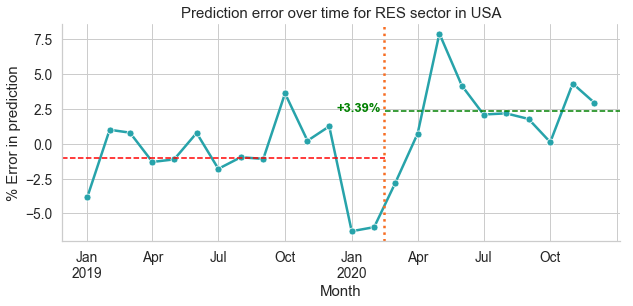

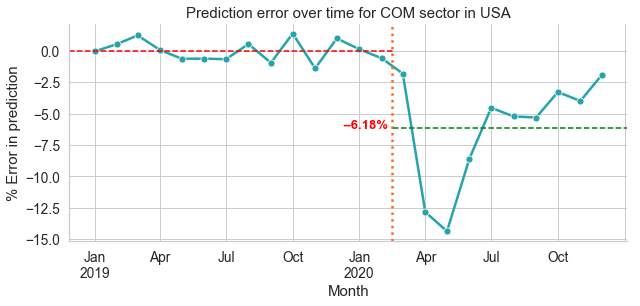

In [85]:
# fig,ax = plt.subplots(3 ,2,figsize=(10,6))
# utils.state_plot(energy_data,'FL','RES',year_lim=2019)
# utils.state_plot(energy_data,'FL','COM',year_lim=2019)
# utils.state_plot(energy_data,'NY','RES',year_lim=2019)
# utils.state_plot(energy_data,'NY','COM',year_lim=2019)
# utils.state_plot(energy_data,'AL','RES',year_lim=2019)
# utils.state_plot(energy_data,'AL','COM',year_lim=2019)
# utils.state_plot(energy_data,'TX','RES',year_lim=2019)
# utils.state_plot(energy_data,'TX','COM',year_lim=2019)
# utils.state_plot(energy_data,'CA','RES',year_lim=2019)
# utils.state_plot(energy_data,'CA','COM',year_lim=2019)
utils.state_plot(energy_data,'USA','RES',year_lim=2019)
utils.state_plot(energy_data,'USA','COM',year_lim=2019)


### Training with 2019 data

In [104]:
# %%timeit
states = list(energy_data.state.unique())
sectors = list(energy_data.sector.unique())
years = [2015,2016,2017,2018,2019,2020]
idx = 0

for year in years:
    for state in states:
        for sector in sectors:
        
            state_sector = "{}-{}".format(state, sector)
#             print(state_sector)
            ## Defining Training Data 
            df_model = energy_data[(energy_data.state == state)&(energy_data.sector == sector)].copy().set_index('date').sort_index()
            df_train, df_test = utils.prepare_data(df_model[['y','heating_days','cooling_days','pct_weekdays']], year)
            regressors_df = df_model[['heating_days','cooling_days','pct_weekdays']].copy()

            ## Fitting model
            m = Prophet(seasonality_mode='multiplicative',yearly_seasonality=5,
                        daily_seasonality=False,weekly_seasonality=False,mcmc_samples=300,
                        changepoint_prior_scale=0.25, changepoint_range=0.95)
            m.add_regressor('heating_days', mode='additive')
            m.add_regressor('cooling_days', mode='additive')
            m.add_regressor('pct_weekdays', mode='additive')
            m_fit = m.fit(df_train,control={'max_treedepth': 15})

            ## Getting forecasts
            future = m_fit.make_future_dataframe(periods = 12, freq = 'MS')
            future = utils.add_regressor_to_future(future, regressors_df)
            forecast = m_fit.predict(future)
            # fig = m_fit.plot(forecast)
            forecast['state'] = state
            forecast['sector'] = sector
            forecast['pred_year'] = year

            if idx == 0:
                predictions = forecast[['ds','yhat','state','sector','pred_year']].copy()    
            else:
                predictions = predictions.append(forecast[['ds','yhat','state','sector','pred_year']])

            idx = idx +1


In [131]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,cooling_days,...,pct_weekdays,pct_weekdays_lower,pct_weekdays_upper,yearly,yearly_lower,yearly_upper,yhat,state,sector,pred_year
151,2020-08-01,195.555179,217.695656,226.946936,192.004987,199.343263,15.586873,12.515442,18.723504,27.109737,...,-0.379338,-0.452837,-0.310320,0.058451,0.045204,0.071788,222.572470,USA,COM,2020
152,2020-09-01,195.298771,206.273985,216.437233,191.320079,199.618794,-1.821256,-3.158057,-0.483344,7.141796,...,0.542205,0.443554,0.647260,0.091659,0.084045,0.099356,211.378344,USA,COM,2020
153,2020-10-01,195.050635,185.729599,196.317869,190.515197,199.893985,-7.858760,-8.568016,-7.092550,-4.056562,...,-0.379338,-0.452837,-0.310320,0.018541,0.013096,0.023906,190.808239,USA,COM,2020
154,2020-11-01,194.794227,174.350062,185.621211,189.693213,200.007592,-9.860424,-11.009848,-8.643496,-9.876789,...,-2.178542,-2.600645,-1.782168,-0.025502,-0.032978,-0.017789,179.966170,USA,COM,2020
155,2020-12-01,194.546091,176.434149,188.149537,188.959176,200.280566,0.927915,-1.081339,2.927233,-12.723598,...,0.937152,0.766642,1.118730,-0.067705,-0.078555,-0.057411,182.302180,USA,COM,2020


In [106]:
predictions.state.value_counts()

WA     1512
GA     1512
NJ     1512
WV     1512
ME     1512
TN     1512
VA     1512
MN     1512
OK     1512
SD     1512
ND     1512
IL     1512
WI     1512
USA    1512
PA     1512
WY     1512
SC     1512
AL     1512
CT     1512
VT     1512
FL     1512
NM     1512
OH     1512
MT     1512
MI     1512
NY     1512
NH     1512
AR     1512
IN     1512
LA     1512
ID     1512
RI     1512
AZ     1512
MD     1512
KY     1512
IA     1512
MS     1512
NE     1512
NC     1512
NV     1512
OR     1512
CO     1512
MO     1512
KS     1512
CA     1512
TX     1512
DC     1512
UT     1512
DE     1512
MA     1512
Name: state, dtype: int64

In [107]:
pred_over_time = predictions[predictions.ds.dt.year==predictions.pred_year].merge(energy_data[['y','date','state','sector']],how='left',left_on=['ds','state','sector'],right_on=['date','state','sector'])

In [108]:
pred_over_time['pct_error'] = (pred_over_time['y'] - pred_over_time['yhat'])*100/pred_over_time['y']

In [109]:
pred_over_time[(pred_over_time.sector=='RES')&(pred_over_time.ds >= '2020-03-01')].sort_values('pct_error')

,ds,yhat,state,sector,pred_year,y,date,pct_error
7065,2020-10-01,27.042765,VA,RES,2020,22.112530,2020-10-01,-22.296114
6146,2020-03-01,21.115146,DC,RES,2020,18.712318,2020-03-01,-12.840892
6866,2020-03-01,26.654786,PA,RES,2020,23.676767,2020-03-01,-12.577812
6779,2020-12-01,47.382235,ND,RES,2020,42.218310,2020-12-01,-12.231484
6057,2020-10-01,31.098539,AR,RES,2020,28.043244,2020-10-01,-10.894941
...,...,...,...,...,...,...,...,...
6172,2020-05-01,20.276787,DE,RES,2020,24.592314,2020-05-01,17.548278
6484,2020-05-01,15.332036,MI,RES,2020,18.724421,2020-05-01,18.117438
6896,2020-09-01,17.030696,RI,RES,2020,21.102041,2020-09-01,19.293608
6634,2020-11-01,17.193893,NV,RES,2020,22.014740,2020-11-01,21.898271


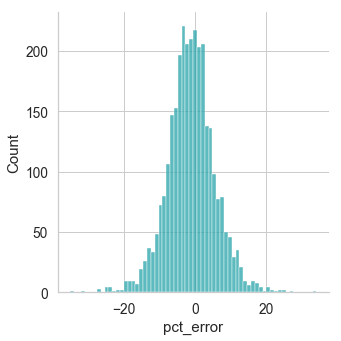

In [110]:
# fig,ax = plt.subplots(figsize=(10,8))
sns.displot(pred_over_time[(pred_over_time.ds.dt.year<2020)&(pred_over_time.sector=='RES')].pct_error)

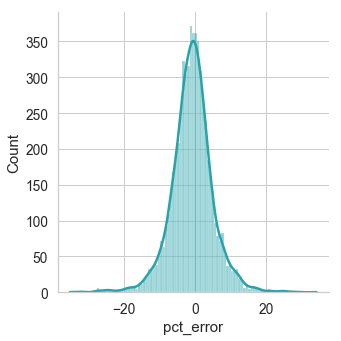

In [111]:
# fig,ax = plt.subplots(figsize=(10,8))
sns.displot(pred_over_time[(pred_over_time.ds.dt.year<2020)].pct_error, kde=True)


In [112]:
pred_over_time[(pred_over_time.ds.dt.year<2020)].pct_error.quantile([0.05,0.1,0.9,0.95])

0.05   -10.046602
0.10    -7.420283
0.90     5.760852
0.95     8.513122
Name: pct_error, dtype: float64

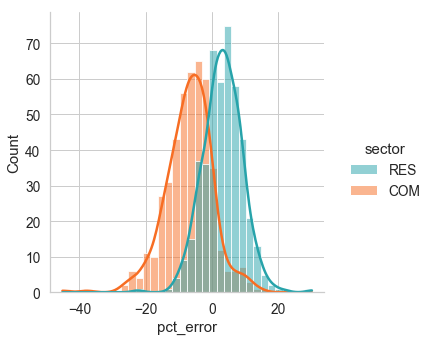

In [113]:
# fig,ax = plt.subplots(figsize=(10,8))
sns.displot(data=pred_over_time[(pred_over_time.ds > '2020-03-01')], x='pct_error', kde=True, hue='sector')

In [114]:
pred_over_time[(pred_over_time.ds >= '2020-03-01')&(pred_over_time.sector=='COM')].pct_error.median()

-5.860997573003642

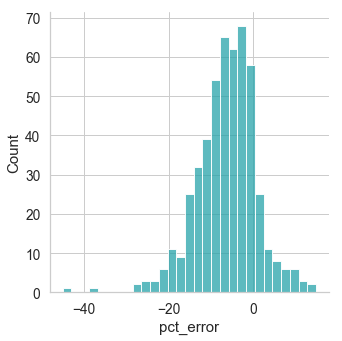

In [115]:
# fig,ax = plt.subplots(figsize=(10,8))
sns.displot(pred_over_time[(pred_over_time.ds >= '2020-03-01')&(pred_over_time.sector=='COM')].pct_error)

In [116]:
predictions_2020 = predictions[predictions.pred_year==2020].rename(columns={'ds':'date','yhat':'yhat_20'})
energy_data = energy_data.merge(predictions_2020,how='left',on=['date','state','sector'])

In [117]:
energy_data

,date,month,sales_mkwh,state,sector,consumers,price,revenue,use_per_capita,region,...,time,year,mon,season,num_days,num_hols,pct_weekdays,y,yhat_20,pred_year
0,2021-01-01,202101,3164.80449,AL,RES,2284207.0,12.380000,3.918028e+04,1385.515625,ESC,...,157,2021,1,winter,31,12,0.612903,44.694052,NaN,NaN
1,2020-12-01,202012,2992.76542,AL,RES,2326166.0,11.390000,3.408760e+04,1286.565714,ESC,...,156,2020,12,winter,31,9,0.709677,41.502120,41.999493,2020.0
2,2020-11-01,202011,2056.87325,AL,RES,2324212.0,12.990000,2.671878e+04,884.976607,ESC,...,155,2020,11,fall,30,11,0.633333,29.499220,29.058566,2020.0
3,2020-10-01,202010,2150.98005,AL,RES,2326554.0,13.170000,2.832841e+04,924.534763,ESC,...,154,2020,10,fall,31,10,0.677419,29.823702,31.083341,2020.0
4,2020-09-01,202009,2876.36566,AL,RES,2325509.0,13.180000,3.791050e+04,1236.875738,ESC,...,153,2020,9,fall,30,9,0.700000,41.229191,43.048960,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15695,2020-11-01,202011,98994.84172,USA,RES,136421078.0,13.287650,1.315409e+06,725.656498,PUS,...,155,2020,11,fall,30,11,0.633333,24.188550,23.010182,2020.0
15696,2020-12-01,202012,103951.57447,USA,COM,18796159.0,10.419035,1.083075e+06,5530.468989,PUS,...,156,2020,12,winter,31,9,0.709677,178.402225,182.302180,2020.0
15697,2020-12-01,202012,129037.22650,USA,RES,137531520.0,12.756682,1.646087e+06,938.237478,PUS,...,156,2020,12,winter,31,9,0.709677,30.265725,29.057532,2020.0
15698,2021-01-01,202101,103755.63610,USA,COM,18733383.0,10.251220,1.063622e+06,5538.542403,PUS,...,157,2021,1,winter,31,12,0.612903,178.662658,NaN,NaN


In [118]:
energy_data['pct_error_20'] = (energy_data['y'] - energy_data['yhat_20'])*100/energy_data['y']

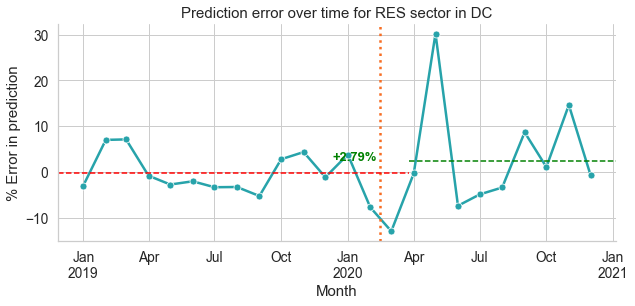

In [119]:
utils.state_plot(energy_data,'DC','RES',year_lim=2019,col='pct_error_20')

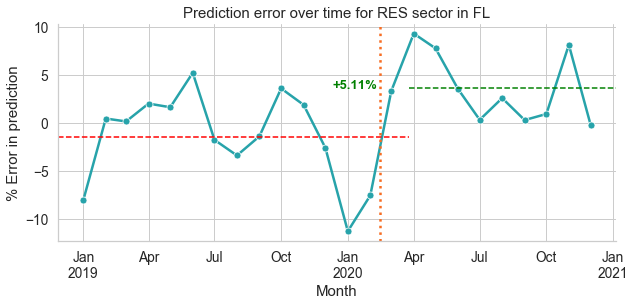

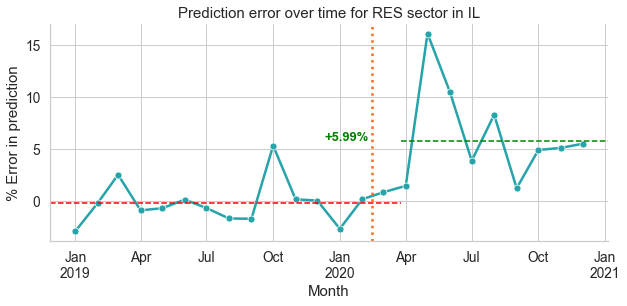

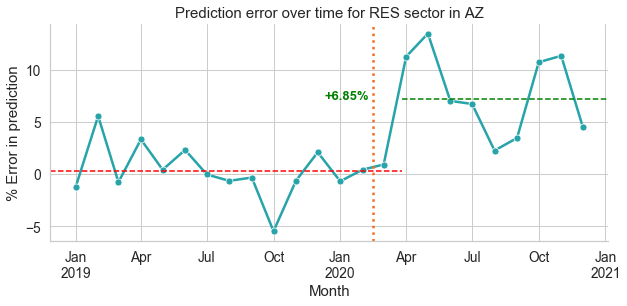

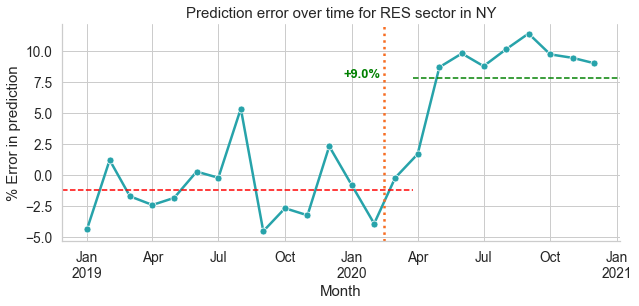

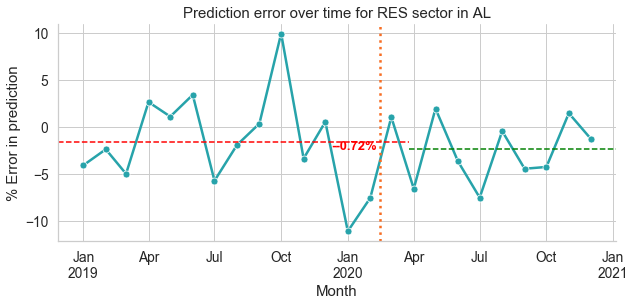

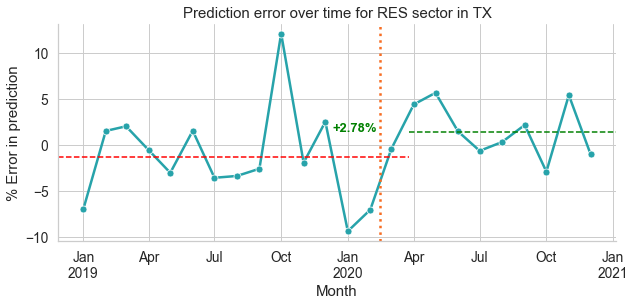

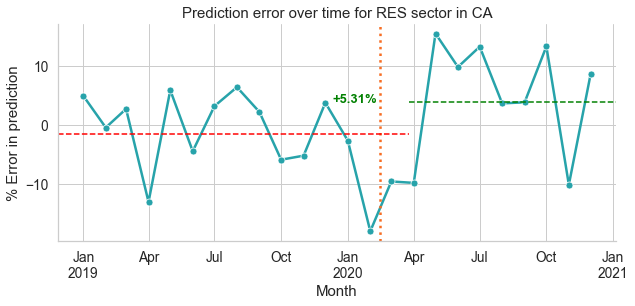

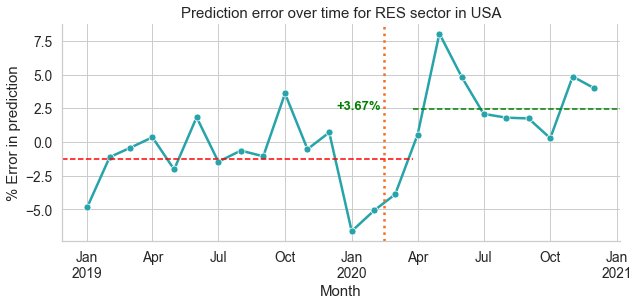

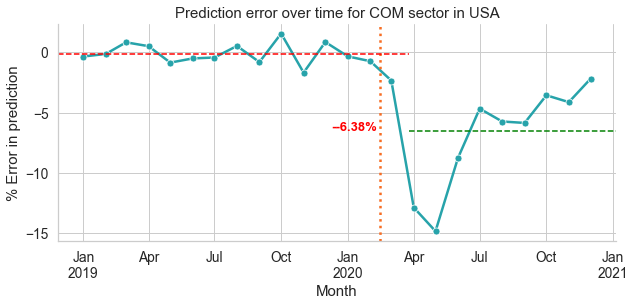

In [120]:
# fig,ax = plt.subplots(3 ,2,figsize=(10,6))
utils.state_plot(energy_data,'FL','RES',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'IL','RES',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'AZ','RES',year_lim=2019,col='pct_error_20')
# utils.state_plot(energy_data,'FL','COM',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'NY','RES',year_lim=2019,col='pct_error_20')
# utils.state_plot(energy_data,'NY','COM',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'AL','RES',year_lim=2019,col='pct_error_20')
# utils.state_plot(energy_data,'AL','COM',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'TX','RES',year_lim=2019,col='pct_error_20')
# utils.state_plot(energy_data,'TX','COM',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'CA','RES',year_lim=2019,col='pct_error_20')
# utils.state_plot(energy_data,'CA','COM',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'USA','RES',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'USA','COM',year_lim=2019,col='pct_error_20')


In [121]:
def mean_errors(df, col='pct_error_20'):
    pre_covid = df[(df.date<'2020-03-01')&(df.date >= '2019-01-01')][col].mean()
    post_covid = df[df.date>='2020-03-01'][col].mean()
    diff = post_covid - pre_covid
    return diff
#     return {'pre_covid':pre_covid, 'post_covid':post_covid}

In [122]:
mean_change = pd.DataFrame(energy_data.groupby(['state','sector']).apply(mean_errors).reset_index().rename(columns={0:'change'}))

In [123]:
mean_res_change = mean_change[mean_change.sector=="RES"]

In [124]:
mean_res_change

,state,sector,change
1,AL,RES,-0.718572
3,AR,RES,-2.268442
5,AZ,RES,6.852447
7,CA,RES,5.307181
9,CO,RES,4.951126
11,CT,RES,7.070641
13,DC,RES,2.793341
15,DE,RES,5.472448
17,FL,RES,5.109964
19,GA,RES,-0.633515


In [125]:
gdf = gpd.read_file('us_states/cb_2018_us_state_5m.shp')

In [126]:
gdf = gdf[gdf.STUSPS.isin(mean_res_change.state)]

In [127]:
gdf = gdf.to_crs("EPSG:2163")

In [128]:
gdf = gdf.merge(mean_res_change, how='left',left_on='STUSPS',right_on='state')

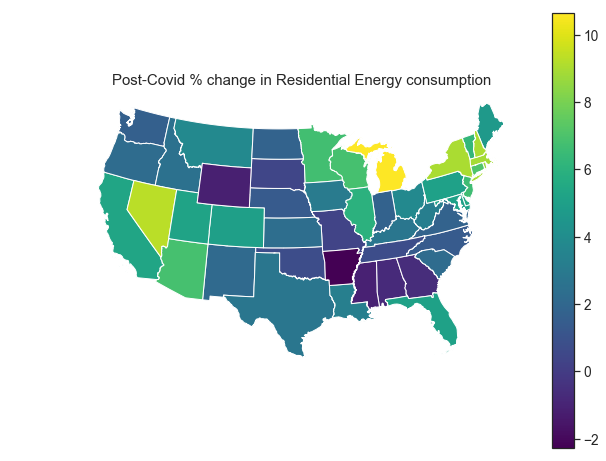

In [129]:
sns.set_style('white')
fig,ax = plt.subplots(figsize=(10,8))
gdf.plot(column='change',ax=ax, legend=True, cmap='viridis')
plt.title("Post-Covid % change in Residential Energy consumption")
ax.set_axis_off()

In [130]:
energy_data.to_csv('energy_data_with_predictions.csv',index=False)

## Statsmodels Time-series analysis

In [ ]:
ts = energy_data[(energy_data.sector=='RES')].copy()
ts['date'] = ts.month + '01'
ts.set_index('date', inplace=True)
ts.index = pd.to_datetime(ts.index)

In [ ]:
state_dummies = pd.get_dummies(ts['state'])
ts = pd.concat([ts,state_dummies],axis=1)

In [ ]:
state_dummies.columns

In [ ]:
from statsmodels.tsa.seasonal import STL

In [ ]:
exog.dropna()

In [ ]:
energy_data['t'] = [x+'01' for x in energy_data.month]
energy_data['date'] = pd.to_datetime(energy_data.t)

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='date',y='use_per_capita',data=energy_data[(energy_data.state=='NY')&(energy_data.sector=='RES')])
plt.ylabel('Montly Use per capita (kwh)')
plt.xlabel('Month')

## Modeling with statsmodels

In [ ]:
## divide by number of days per month
## Weekends per month


In [ ]:
## GEt NY ISO granular data (15 min resolution)

In [63]:
state_level_data =  energy_data[energy_data.state != 'USA'].copy()

In [64]:
state_level_data['year_l1'] = state_level_data.year - 1
state_level_data['mon_l1'] = state_level_data.mon - 1
state_level_data = state_level_data.merge(state_level_data[['year','mon','state','sector','use_per_capita']].rename(columns={'year':'year_l1','use_per_capita':'y_sl1'}),how='left',left_on=['year_l1','mon','state','sector'],right_on=['year_l1','mon','state','sector'])
state_level_data = state_level_data.merge(state_level_data[['year','mon','state','sector','use_per_capita']].rename(columns={'mon':'mon_l1','use_per_capita':'y_l1'}),how='left',left_on=['year','mon_l1','state','sector'],right_on=['year','mon_l1','state','sector'])

In [65]:
state_level_data.head()

,date,month,sales_mkwh,state,sector,consumers,price,revenue,use_per_capita,region,...,y,yhat,pct_error,yhat_20,pred_year,pct_error_20,year_l1,mon_l1,y_sl1,y_l1
0,2021-01-01,202101,3164.80449,AL,RES,2284207.0,12.38,39180.279586,1385.515625,ESC,...,44.694052,NaN,NaN,NaN,NaN,NaN,2020,0,1180.712039,NaN
1,2020-12-01,202012,2992.76542,AL,RES,2326166.0,11.39,34087.598134,1286.565714,ESC,...,41.502120,NaN,NaN,42.017221,2020.0,-1.241145,2019,11,1147.520179,884.976607
2,2020-11-01,202011,2056.87325,AL,RES,2324212.0,12.99,26718.783518,884.976607,ESC,...,29.499220,NaN,NaN,29.031823,2020.0,1.584441,2019,10,1014.802728,924.534763
3,2020-10-01,202010,2150.98005,AL,RES,2326554.0,13.17,28328.407259,924.534763,ESC,...,29.823702,NaN,NaN,31.089942,2020.0,-4.245752,2019,9,1067.414260,1236.875738
4,2020-09-01,202009,2876.36566,AL,RES,2325509.0,13.18,37910.499399,1236.875738,ESC,...,41.229191,48.538083,-17.727468,43.045742,2020.0,-4.405981,2019,8,1479.880239,1536.328624


In [66]:
state_level_data = state_level_data.dropna()

In [67]:
state_level_data['yhat'] = np.NaN
# state_level_data['yhat_20'] = np.NaN

In [68]:
mod_19_res = smf.ols(formula='use_per_capita ~  time + y_sl1 + heating_days + cooling_days + C(state)', data=state_level_data[(state_level_data.year < 2019)&(state_level_data.sector=='RES')])
mod_20_res = smf.ols(formula='use_per_capita ~  time + y_sl1 + heating_days + cooling_days + C(state)', data=state_level_data[(state_level_data.year < 2020)&(state_level_data.sector=='RES')])
mod_19_com = smf.ols(formula='use_per_capita ~  time + y_sl1 + heating_days + cooling_days + C(state)', data=state_level_data[(state_level_data.year < 2019)&(state_level_data.sector=='COM')])
mod_20_com = smf.ols(formula='use_per_capita ~  time + y_sl1 + heating_days + cooling_days + C(state)', data=state_level_data[(state_level_data.year < 2020)&(state_level_data.sector=='COM')])

In [69]:
res_19_res = mod_19_res.fit()
res_20_res = mod_20_res.fit()
res_19_com = mod_19_com.fit()
res_20_com = mod_20_com.fit()



In [ ]:
# md = smf.mixedlm('use_per_capita ~ time + time^2 + y_l1 + heating_days + cooling_days', data=state_level_data[(state_level_data.year < 2019)&(state_level_data.sector=='COM')&(state_level_data.region=='ESC')], groups=state_level_data[(state_level_data.year < 2019)&(state_level_data.sector=='COM')&(state_level_data.region=='ESC')]["state"])
# mdf = md.fit()
# print(mdf.summary())

In [ ]:
print(res_19_com.summary())

## To Do:
- Outcome variable: Average per day
- % of days that are weekends or holidays
- 1 month lagged (AR-1), last 3 month average
- % above last 12m avg usage

- Stan model
- Take pieces from Prophet (fourier expansion for seasonality): get the stan code
- weather data maybe

In [70]:
state_level_data.set_index('date',inplace=True)

In [71]:
state_level_data.loc[(state_level_data.year<=2019)&(state_level_data.sector=='RES'),'yhat'] = res_19_res.predict(state_level_data[(state_level_data.year<=2019)&(state_level_data.sector=='RES')])
state_level_data.loc[(state_level_data.year==2020)&(state_level_data.sector=='RES'),'yhat'] = res_20_res.predict(state_level_data[(state_level_data.year==2020)&(state_level_data.sector=='RES')])
state_level_data.loc[(state_level_data.year<=2019)&(state_level_data.sector=='COM'),'yhat'] = res_19_com.predict(state_level_data[(state_level_data.year<=2019)&(state_level_data.sector=='COM')])
state_level_data.loc[(state_level_data.year==2020)&(state_level_data.sector=='COM'),'yhat'] = res_20_com.predict(state_level_data[(state_level_data.year==2020)&(state_level_data.sector=='COM')])

KeyError: "None of ['date'] are in the columns"

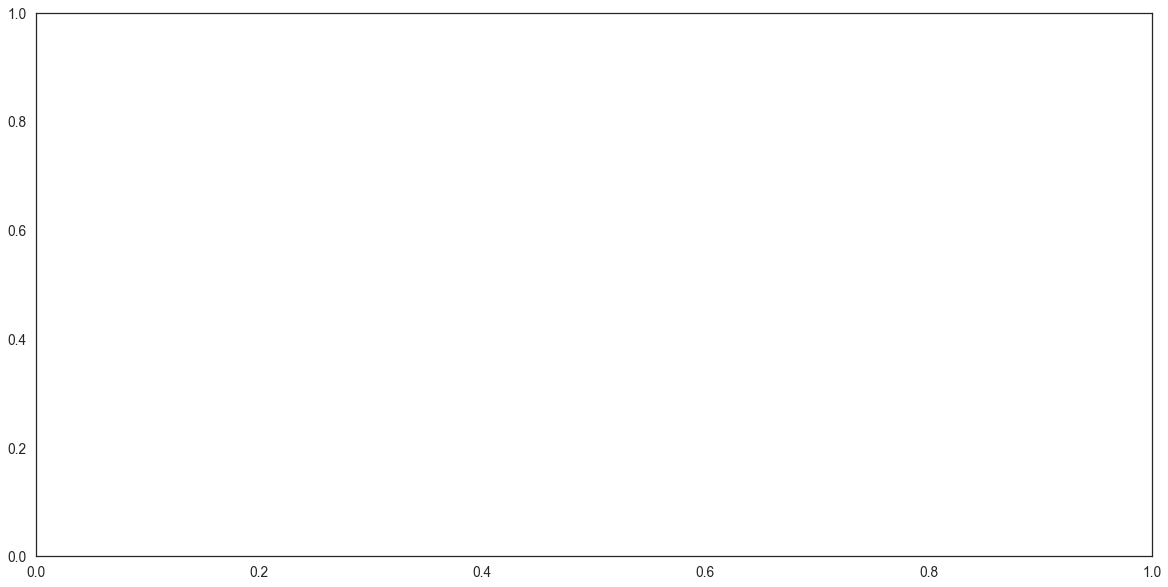

In [72]:
fig,ax = plt.subplots(figsize=(20,10))
df_plot = state_level_data[(state_level_data.state=='NY')&(state_level_data.sector=='RES')].copy()
df_plot = df_plot.set_index('date')
df_plot.loc[df_plot.year == 2020, 'yhat'] = np.NaN
df_plot = df_plot[['use_per_capita','yhat']].rename(columns={'use_per_capita':'Actual','yhat':'Predicted'})
sns.lineplot(data=df_plot)
plt.ylabel('Montly Use per capita (kwh)')
plt.xlabel('Month')


In [73]:
state_level_data['pct_error'] = (state_level_data['use_per_capita'] - state_level_data['yhat'])*100/state_level_data['use_per_capita']
# state_level_data['pct_error_20'] = (state_level_data['yhat_20'] - state_level_data['use_per_capita'])*100/state_level_data['use_per_capita']

In [ ]:
sns.boxplot(x='sector',y='pct_error',data=state_level_data)

In [ ]:
state_level_data = state_level_data.set_index('month').sort_index()

In [ ]:
state_level_data[(state_level_data.mon == 2)&(state_level_data.state=='CA')&(state_level_data.sector=='RES')].use_per_capita.plot()

In [ ]:
sns.boxplot(x='mon',y='pct_error',data=state_level_data[state_level_data.sector=='COM'])

In [ ]:
sns.boxplot(x='mon',y='pct_error_19',data=state_level_data[state_level_data.sector=='RES'])

In [ ]:
sns.boxplot(x='mon',y='pct_error_19',data=state_level_data[state_level_data.sector=='COM'])

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
sns.boxplot(x='state',y='pct_error_19',data=state_level_data[state_level_data.sector=='RES'])

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
sns.boxplot(x='state',y='pct_error_19',data=state_level_data[state_level_data.sector=='COM'])

In [ ]:
state_level_data.pct_error_19.plot()

In [ ]:
df_plot = state_level_data[(state_level_data.state == 'NY')&(state_level_data.sector=='RES')&(state_level_data.year>=2019)]

In [ ]:
df_plot.set_index('month').sort_index().pct_error.plot()

In [ ]:
df_plot = state_level_data[(state_level_data.state == 'NY')&(state_level_data.sector=='COM')&(state_level_data.year>=2019)]

In [ ]:
df_plot.set_index('month').sort_index().pct_error.plot()

In [ ]:
state_level_data.head()

In [ ]:
state_level_data.reset_index(inplace=True)

In [32]:
def state_plot(df, state, sector, year_lim=2019):
    df_plot = df[(df.state==state)&(df.sector==sector)&(df.year>=year_lim)].copy()
    fig,ax = plt.subplots(figsize=(15,6))
    mean_error_before = df_plot[(df_plot.date<'2020-03-01')].pct_error.mean()
    mean_error_after = df_plot[(df_plot.date>='2020-03-01')].pct_error.mean()
    
    df_plot = df_plot.set_index('date')
    df_plot.pct_error.plot(ax=ax)
    plt.xlabel('Month')
    plt.ylabel('% Error in prediction')
    plt.axvline(x=datetime(2020,3,1),color='#f76d23',linestyle='dotted')
    plt.axhline(y=mean_error_before, xmin=0, xmax=0.67, color='r', linestyle='--')
    plt.axhline(y=mean_error_after, xmin=0.67, xmax=1, color='g', linestyle='--')
    plt.text(x=datetime(2020,3,1),y=((mean_error_after+mean_error_before)/2),s= "{}% change".format(np.round(mean_error_after-mean_error_before,2)))
    
#     plt.axvline()

In [62]:
state_plot(state_level_data,'NY','RES')

NameError: name 'state_level_data' is not defined

In [ ]:
state_plot(state_level_data,'NY','COM')